In [11]:
from inception import InceptionV3
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys

In [2]:
from cycler import cycler
my_cycler = (cycler(color=['#94c8d8','#FE9A84','#296540','#E63F39','#C3AAD1',
              '#D5AC5A','#F4B6C3','#B4BCCA','#DBD468','#B1D3E1','#8b1821']))

fh = 15
plt.rcParams['figure.figsize'] = (18,12)
plt.rcParams['axes.prop_cycle'] = my_cycler
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 9#12
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = fh
plt.rcParams['xtick.labelsize'] = fh
plt.rcParams['ytick.labelsize'] = fh
plt.rcParams['axes.titlesize'] = fh
plt.rcParams['figure.titlesize'] = fh

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(trainset.data.shape)
print(len(trainset.targets))

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
50000


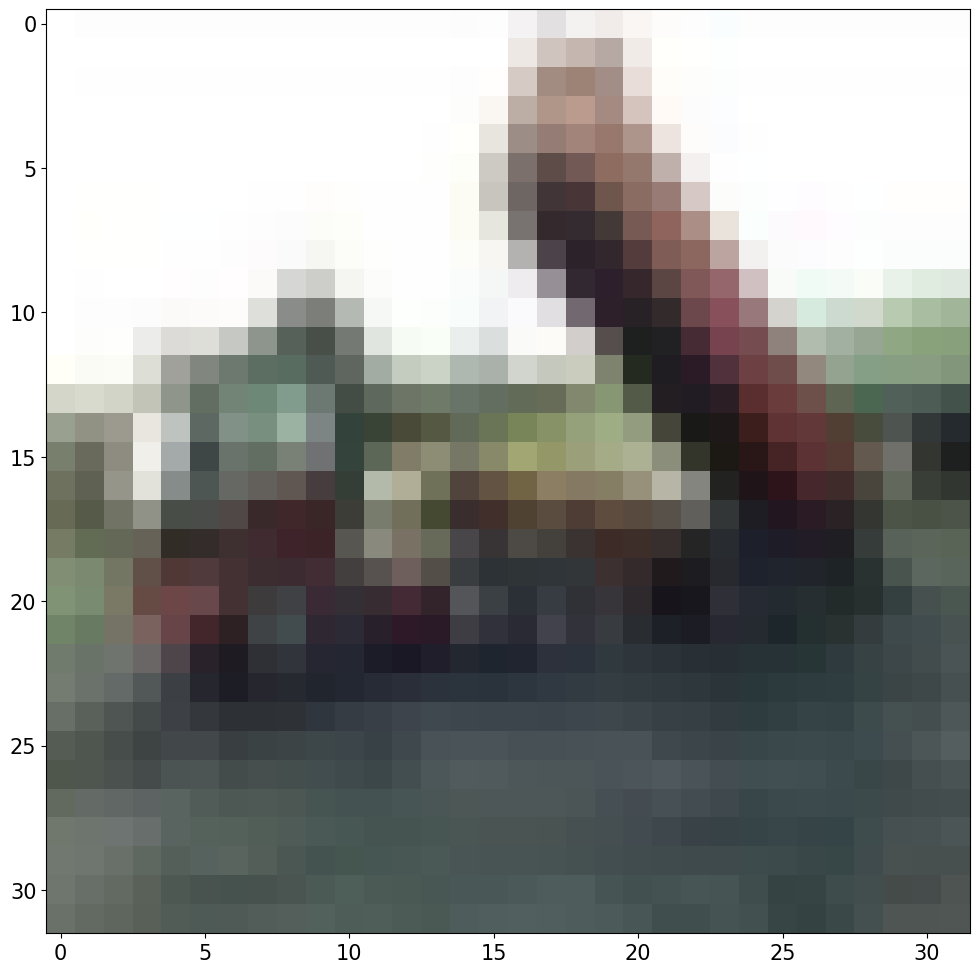

In [4]:
plt.imshow(trainset.data[2,:,:,:])

In [5]:
def compute_statistics_of_path(path, model, batch_size, dims, device,
                               num_workers=1):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        path = pathlib.Path(path)
        files = sorted([file for ext in IMAGE_EXTENSIONS
                       for file in path.glob('*.{}'.format(ext))])
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, device, num_workers)

    return m, s

In [6]:
def calculate_activation_statistics(files, model, batch_size=50, dims=2048,
                                    device='cpu', num_workers=1):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, device, num_workers)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [7]:
def get_activations(files, model, batch_size=50, dims=2048, device='cpu',
                    num_workers=1):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=num_workers)

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in tqdm(dataloader):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr

In [8]:
device = torch.device('cuda:0')
dims = 2048

In [9]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

In [20]:
model.eval()

with torch.no_grad():
    for xx,yy in trainloader:
        xx = xx.to(device)
        print(xx.shape)
        out = model(xx)[0]
        print(out.shape)
        pred = out.cpu().numpy().transpose(0, 2, 3, 1).reshape(1*out.shape[2]*out.shape[3],-1)
        print(pred.shape)
        
        sys.exit()

torch.Size([4, 3, 32, 32])
torch.Size([4, 2048, 1, 1])
(1, 8192)


SystemExit: 